In [1]:
from beexai.dataset.dataset import Dataset
from beexai.explanation.explaining import CaptumExplainer
from beexai.evaluate.metrics.get_results import get_all_metrics

In [2]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.inspection import permutation_importance

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


# Load TabNet

In [3]:
retrain = False

data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features = data["df_select_features"]
df_select_features.columns = ["RNA", "CSF", "DNA", "MRIth"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

In [4]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [5]:
with open("../pickle/training_2_dict_results.pickle", "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [6]:
if retrain : 
    tabnet_model =  TabNetModelWrapper(n_a=8, n_d=8)#   XGBoostRegressor() #  TabNetModelWrapper(n_a=8, n_d=8)
else :  
    tabnet_model = all_dict_results[9]["model"] # Corresponds to TabNet trained in notebook #3  

continuous_model  = imputer = KNNImputer(n_neighbors=5)
name_continuous_imputer  = "KNNImputer_5"
ordinal_model =  KNNImputer(n_neighbors=1)
name_ordinal_imputer = "KNNImputer"
name_model = "TabNetRegressor" # "XGBoostRegressor"#  "TabNetRegressor"

In [7]:
ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

# Separate imputers for ordinal and continuous data
print("Using separate imputers for ordinal and continuous data.")

df_X_train = df_X_train.copy()
df_X_test = df_X_test.copy()

for col in ordinal_features:
    df_X_train[col] = df_X_train[col].astype("category")
    df_X_test[col] = df_X_test[col].astype("category")

# Continuous Imputation Transformer (Example: SimpleImputer)
continuous_imputer = Pipeline([
    (name_continuous_imputer, continuous_model),
])

# Ordinal Imputation Transformer (Example: KNN Imputer)
ordinal_imputer = Pipeline([
    (name_ordinal_imputer, ordinal_model)
])

# Create a ColumnTransformer to apply the appropriate imputer to each type of variable
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_imputer, ordinal_features),
        ('continuous', continuous_imputer, continuous_features)
    ],
    remainder='passthrough'
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

    # Separate imputers for ordinal and continuous data

# Fit and transform, then convert back to DataFrame with original column names
start = time.time()
pipeline.fit(df_X_train)
end = time.time()

impute_model_time = end - start

X_train_imputed = pipeline.transform(df_X_train)
df_X_train_imputed = df_X_train.copy()
df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

# Transform the test set
if df_X_test.isna().any().any(): 
    X_test_imputed = pipeline.transform(df_X_test)
    df_X_test_imputed = df_X_test.copy()
    df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
else : 
    print("No NaN in test data -> Keep as it is. ")
    df_X_test_imputed = df_X_test

df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category", errors='ignore')
df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category", errors='ignore')

# Demographics adjustment for y
demographic_adjustment_y = DemographicAdjustmentTransformer()

y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

# Demographics adjustment for X
demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

# Standardize only continuous features
scaler = StandardScaler()

X_train_adjusted[continuous_features] = scaler.fit_transform(X_train_adjusted[continuous_features])
X_test_adjusted[continuous_features] = scaler.transform(X_test_adjusted[continuous_features])

if retrain: 
    # Perform prediction and save variables
    start = time.time()
    tabnet_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start
    print("Training time: ", end - start)
else : 
    predict_model_time = None

y_pred_adjusted = tabnet_model.predict(X_test_adjusted)

y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

# Metrics computed in original space
y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

params = {
    "ordinal_imputer": name_ordinal_imputer, 
    "continuous_imputer": name_continuous_imputer, 
    "model": name_model, "train_shape" : X_train_adjusted.shape, 
    "test_shape": X_test_adjusted.shape
}

def compute_all_metrics(y_test, y_pred): 
    # Metrics computed in adjusted space
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    r2 = r2_score(y_test,y_pred, multioutput="raw_values")
    explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

    try: 
        corr_p = correlation(y_pred, y_test)
    except: 
        print("Problem when computing correlation!")
        if type(y_test) != type(y_pred): 
            print("Type of inputs is different.")
            corr_p = None
        else : 
            corr_p = pearsonr(y_test, y_pred)

    return mse_score, mae_score, r2, explained_variance, corr_p

if df_X_test.shape[0] != 1: 

    # Metrics computed in adjusted space
    mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

    results_adj = {
        "mse_score": mse_score_adj, 
        "mae_score":mae_score_ajd, 
        "r2":r2_adj, 
        "explained_variance":explained_variance_adj, 
        "corr":corr_adj, 
    }

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

    results_org = {
        "mse_score": mse_score, 
        "mae_score": mae_score, 
        "r2": r2, 
        "explained_variance": explained_variance, 
        "corr": corr, 
    }
    
    print("Saving predictions in dict!")
    results_adj = {
        "y_pred": y_pred_adjusted.values, 
        "y_test": y_test_adjusted.values,
    }

    results_org = {
        "y_pred": y_pred.values, 
        "y_test": df_y_test.values,
    }


dict_results = {
    "params": params, 
    "imputation_time": impute_model_time,
    "fitting_time": predict_model_time, 
    "results_adj": results_adj, 
    "results_org": results_org
    }

Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
Saving predictions in dict!


In [8]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

Domain: ADNI_MEM, Pearson correlation: 0.678, Pearson p-value: 0.011, MAE: 0.677
Domain: ADNI_EF, Pearson correlation: 0.722, Pearson p-value: 0.005, MAE: 0.633
Domain: ADNI_VS, Pearson correlation: 0.553, Pearson p-value: 0.050, MAE: 0.473
Domain: ADNI_LAN, Pearson correlation: 0.556, Pearson p-value: 0.049, MAE: 0.749


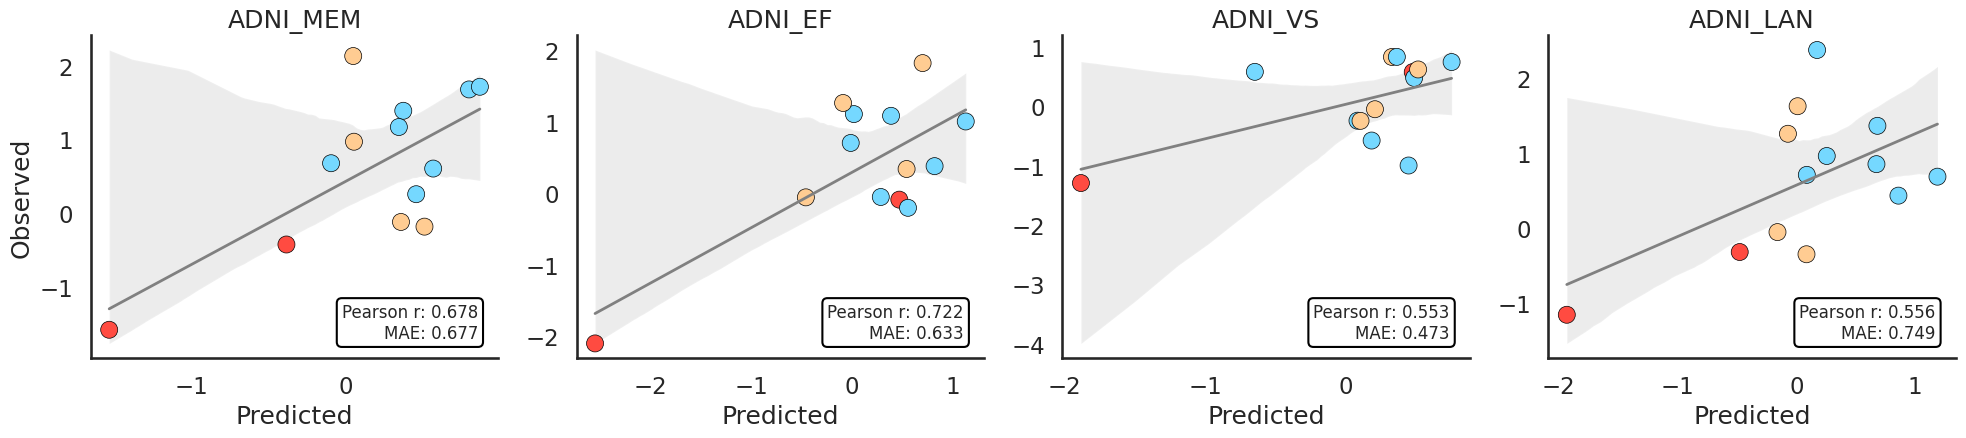

In [10]:
# Set style with no grid and larger context
sns.set_style("white")
sns.set_context("talk")  # Larger font sizes

# Create the lmplot without scatter points and no title
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # No scatter points from lmplot
    line_kws={"color": "grey", "lw": 2},
    legend=False  # No legend from lmplot
)

# Overlay scatter points with large size and annotations
cognitive_domains_order = g.col_names

for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]

    # Scatter points
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=150,  # Bigger scatter points
        edgecolor='black',  # Optional for clarity
        linewidth=0.5,
        legend=False  # No legend from scatterplot
    )
    
    # Legend styling
    ax.legend(loc="upper left", title="Diagnosis", fontsize=12, title_fontsize=13)
    
    # Metrics
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])

    print(f"Domain: {cognitive_domain}, Pearson correlation: {pearsonr(group_data['y_pred'], group_data['y_test'])[0]:.3f}, Pearson p-value: {pearsonr(group_data['y_pred'], group_data['y_test'])[1]:.3f}, MAE: {mae:.3f}")
    
    # Annotation
    ax.text(
        0.95, 0.05,
        f"Pearson r: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
    ax.legend_.remove()  # Remove legend from each subplot

# Axis labels
g.set_axis_labels("Predicted", "Observed")
g.set_titles("{col_name}")  # Removes subtitle formatting

# Remove the main title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("")  # Set to empty to remove title

# Final layout cleanup
sns.despine()
plt.tight_layout()
plt.show()


## Choose an explanation 

In [23]:
results = {}
for method in ["FeatureAblation", "KernelShap", "Lime"]:
    expl = CaptumExplainer(tabnet_model, task="regression", method=method, sklearn=True)
    expl.init_explainer()
    results[method] = get_all_metrics(X_test_adjusted, y_pred.ADNI_MEM, tabnet_model, expl, print_plot=False)
print(results)

AssertionError: Input tensor and attributions tensor must have the same shape.
            Found shapes torch.Size([13, 256]) and torch.Size([52, 256])

In [33]:
model_instance = tabnet_model.model
# 1. Init explainer
explainer = CaptumExplainer(model_instance, task="regression",
                            method="ShapleyValueSampling", sklearn=False)
explainer.init_explainer()

y_pred = model_instance.predict(X_test_adjusted)

attributions = explainer.compute_attributions(X_test_adjusted, "mydata", "TabNet",
                                               "ShapleySampling", None, use_abs=True)

# 3. Evaluate
metrics = get_all_metrics(X_test_adjusted, y_pred, model_instance, explainer,
                          baseline="zero", auc_metric="mse",
                          print_plot=True, save_path=None, device="cpu")

print(metrics)

KeyError: 0